In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
from tensorflow import keras
from gensim.models import word2vec
import neattext as nfx
import re
from nltk.corpus import stopwords
from glob import glob
import torch.nn.functional as F
from transformers import AutoTokenizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from bs4 import BeautifulSoup
import html

E:\Users\DEATHFREAK\anaconda3\envs\ev_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Data Accessing

In [16]:
books = pd.read_csv('preprocessed_data.csv')

In [17]:
books.head(6)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
5,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada


In [20]:
print(books.Summary[7598])

In a futuristic military adventure a recruit goes through the roughest
boot camp in the universe and into battle with the Terran Mobile
Infantry in what historians would come to call the First Interstellar
War


In [21]:
books.columns

Index(['Unnamed: 0', 'user_id', 'location', 'age', 'isbn', 'rating',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city',
       'state', 'country'],
      dtype='object')

In [22]:
books = books[['isbn', 'rating',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_s', 'img_m', 'img_l', 'Summary', 'Language']]

In [23]:
books.head(56)

,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language
0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en
1,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
2,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
3,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
4,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
5,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
6,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
7,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
8,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
9,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en


# Filling Missing Values

In [24]:
# Check for missing values in the entire DataFrame
books.isna().sum()

isbn                   0
rating                 0
book_title             0
book_author            1
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
Summary                0
Language               0
dtype: int64

In [26]:
# Remove rows with any missing values
books= books.dropna()

In [27]:
books.head(7)

,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language
0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en
1,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
2,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
3,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
4,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
5,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
6,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en


In [30]:
print(books.Summary[1900])

Wild animus is a search for the primordial, a test of human
foundations and a journey to the breaking point.


# Data Cleaning

In [33]:
# the following line applies the 'nfx.remove_html_tags' function to each element in the 'Summary' column.
# This function is designed to remove HTML tags from the text, ensuring cleaner and more readable summaries.
books['Summary'] = books['Summary'].apply(nfx.remove_html_tags)

In [34]:
dir(nfx)

['AUTOMATED_READ_INDEX',
 'BTC_ADDRESS_REGEX',
 'CONTRACTIONS_DICT',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Callable',
 'Counter',
 'CreditCard_REGEX',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'FUNCTORS_WORDLIST',
 'HASTAG_REGEX',
 'HTML_TAGS_REGEX',
 'List',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PUNCT_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextCleaner',
 'TextExtractor',
 'TextFrame',
 'TextMetrics',
 'TextPipeline',
 'Tuple',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 'ZIP_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'clean_text',
 'defaultdict',
 'digit2words',
 'emoji_explainer',
 'emojify',
 'explainer',
 'extract_btc_address',
 

In [12]:
# This line ensures that only rows with valid 'Summary' data are retained in the 'books' DataFrame
books = books[~books['Summary'].isna()]

In [35]:
books['Summary'][40]

'A Chinese immigrant who is convinced she is dying threatens to\ncelebrate the Chinese New Year by unburdening herself of\neverybody&#39;s hidden truths, thus prompting a series of comic\nmisunderstandings'

In [36]:
books.head(8)

,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language
0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en
1,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
2,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
3,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
4,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
5,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
6,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en
7,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en


In [31]:
# The function takes an optional parameter 'sample' to specify the number of random values to display.
def check_text(sample=20):
  for i in range(sample):
    print(f'{i+1}) {books.Summary.sample(sample).iloc[i]}\n')

In [32]:
check_text(10)

1) The author provides narratives and insights on familiar Bible stories
of the New Testament.

2) Locked Up With A Lawman by Laura Wright released on Nov 24, 2003 is
available now for purchase.

3) 9

4) Presents a series of stories about men and women who, representing
both medical and literary oddities, raise fundamental questions about
the nature of reality

5) 9

6) 9

7) Winner of the Pulitzer Prize A metaphorical fugue on minds and
machines in the spirit of Lewis Carroll Douglas Hofstadter&#39;s book
is concerned directly with the nature of &quot;maps&quot; or links
between formal systems.

8) 9

9) Adam, an aspiring third-year medical student, fights to save his wife
Jennifer and their unborn child from the overwhelming evil he uncovers
at Arolen Pharmaceuticals. Reissue.

10) 9



In [37]:
books.replace(to_replace='9', value='not specified', inplace=True)

In [38]:
check_text(10)

1) Explains the basic concepts of the Chinese philosophy of Taoism
through a discussion of how Winnie-the-Pooh lives by its principles

2) Reprint. &quot;TAN HAS ONCE MORE PRODUCED A NOVEL WONDERFULLY LIKE A
HOLOGRAM: turn it this way and find Chinese-Americans shopping and
arguing in San Francisco; turn it that way and the Chinese of
Changmian village in 18

3) Snow Baby by Brenda Novak released on Aug 25, 2000 is available now
for purchase.

4) Remembering a past time when the gods walked the lands among mortals,
an ancient man known as the Old Wolf recounts the tale of his youth,
during which he witnessed the strife that split the world in two

5) Follows two teenagers coming of age in the midst of the Bronx drug
trade as they experience budding sexuality, teen parenthood, and gang
identity in a social examination of the challenges of family life in
the face of violence.

6) Reviews the individuals, tactics, and events involved in Field Marshal
Bernard Law Montgomery&#39;s plan to e

In [39]:
books.head

<bound method NDFrame.head of                isbn  rating  \
0        0195153448       0   
1        0002005018       5   
2        0002005018       0   
3        0002005018       8   
4        0002005018       0   
...             ...     ...   
1031170  0743203763       0   
1031171  0767907566       5   
1031172  0884159221       7   
1031173  0912333022       7   
1031174  1569661057      10   

                                                book_title  \
0                                      Classical Mythology   
1                                             Clara Callan   
2                                             Clara Callan   
3                                             Clara Callan   
4                                             Clara Callan   
...                                                    ...   
1031170  As Hogan Said . . . : The 389 Best Things Anyo...   
1031171  All Elevations Unknown: An Adventure in the He...   
1031172  Why stop?: A guide to Texas hi

In [40]:
books = books.sample(n=80000)
books.head

<bound method NDFrame.head of               isbn  rating                                         book_title  \
536340  0531070549       0  A Friend for Dragon: Dragon's First Tale (The ...   
326375  0380423901      10                              Woman of Independence   
927001  0340770333       8            The Stretch (Stephen Leather Thrillers)   
255311  0312983271       8         Full House (Janet Evanovich's Full Series)   
328644  0449205878       0                                             Poland   
...            ...     ...                                                ...   
461621  0787100110       0                      Kaffir Boy (Super Sound Buys)   
873615  0373117280       9  Marriage In Jeopardy (Harlequin Presents, No 1...   
926874  2804001601       7               Le trÃ©sor des humbles (Espace nord)   
548785  0897334779       0                                  The Other Rebecca   
724788  0345330005      10          Guardians of the West (Malloreon, Book 1)  

# Model Building

# Applying emotion text classifier by Michelle Jieli
This transformer has six classes.

In [2]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('michellejieli/emotion_text_classifier')
model = TFAutoModelForSequenceClassification.from_pretrained('michellejieli/emotion_text_classifier', from_pt=True)

def emotion_classifier(text):
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='tf'
    )

    outputs = model(inputs)
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=1)
    predicted_class = tf.argmax(probabilities, axis=1)
    scores = probabilities[0, predicted_class[0]].numpy()
    label = model.config.id2label[predicted_class[0].numpy()]

    return [{'label': label, 'scores': scores}]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [7]:
emotion_classifier('I am feeling quite joyful today!')

[{'label': 'joy', 'scores': 0.99540544}]

In [16]:
emotion = books.Summary.apply(lambda x: emotion_classifier(x))
emotion

868939     [{'label': 'neutral', 'scores': 0.96856153}]
972494     [{'label': 'neutral', 'scores': 0.96856153}]
390146     [{'label': 'neutral', 'scores': 0.96856153}]
999794     [{'label': 'neutral', 'scores': 0.96856153}]
1024364    [{'label': 'neutral', 'scores': 0.96856153}]
                               ...                     
487997     [{'label': 'neutral', 'scores': 0.96856153}]
932303     [{'label': 'neutral', 'scores': 0.96856153}]
864280     [{'label': 'neutral', 'scores': 0.46261877}]
777391      [{'label': 'neutral', 'scores': 0.9271944}]
604920     [{'label': 'neutral', 'scores': 0.91615826}]
Name: Summary, Length: 80000, dtype: object

In [17]:
# Extracting labels from a list of dictionaries stored in the 'emotion' variable.
# The loop iterates over each dictionary in the 'emotion' list and appends the value associated with the 'label' key to the 'label' list.
label = []
for i in emotion:
  label.append(i[0]['label'])
label = pd.Series(label)
label.values

array(['neutral', 'neutral', 'neutral', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [18]:
# Adding the values in 'label' to a new column called 'Emotions'
books['Emotions'] = label.values
books.head()

,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Emotions
868939,2253040738,0,Manipulations,Robin Cook,1987.0,LGF,http://images.amazon.com/images/P/2253040738.0...,http://images.amazon.com/images/P/2253040738.0...,http://images.amazon.com/images/P/2253040738.0...,not specified,not specified,neutral
972494,0151555613,0,Maigret in Court,Georges Simenon,1983.0,Harcourt,http://images.amazon.com/images/P/0151555613.0...,http://images.amazon.com/images/P/0151555613.0...,http://images.amazon.com/images/P/0151555613.0...,not specified,not specified,neutral
390146,0679742581,10,Caramelo,SANDRA CISNEROS,2003.0,Vintage,http://images.amazon.com/images/P/0679742581.0...,http://images.amazon.com/images/P/0679742581.0...,http://images.amazon.com/images/P/0679742581.0...,not specified,not specified,neutral
999794,0812575644,0,"The Vanished (Outer Limits, No 7)",John Peel,1998.0,Tor Books,http://images.amazon.com/images/P/0812575644.0...,http://images.amazon.com/images/P/0812575644.0...,http://images.amazon.com/images/P/0812575644.0...,not specified,not specified,neutral
1024364,1588468003,9,Chosen of the Sun (Exalted: Trilogy of the Sec...,Richard Dansky,2001.0,White Wolf Publishing,http://images.amazon.com/images/P/1588468003.0...,http://images.amazon.com/images/P/1588468003.0...,http://images.amazon.com/images/P/1588468003.0...,not specified,not specified,neutral


In [22]:
#Creating a new csv file for the processed data
books.to_csv('Completed-Books-with-Emotions.csv')

In [18]:
emotion_classifier("The commitment of volunteers can inspire community engagement")

[{'label': 'joy', 'scores': 0.64955527}]

<AxesSubplot:>

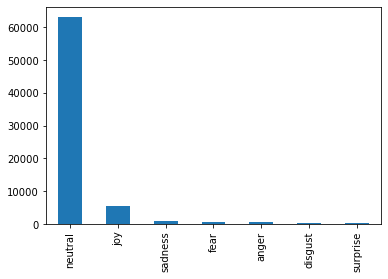

In [16]:
books['Emotions'].value_counts().plot(kind='bar')

In [6]:
neutral_rows = books[books['Emotions']== 'neutral'].sample(n=50000)
books = books.drop(neutral_rows.index)

In [15]:
books.head(12)

,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language
868939,2253040738,0,Manipulations,Robin Cook,1987.0,LGF,http://images.amazon.com/images/P/2253040738.0...,http://images.amazon.com/images/P/2253040738.0...,http://images.amazon.com/images/P/2253040738.0...,not specified,not specified
972494,0151555613,0,Maigret in Court,Georges Simenon,1983.0,Harcourt,http://images.amazon.com/images/P/0151555613.0...,http://images.amazon.com/images/P/0151555613.0...,http://images.amazon.com/images/P/0151555613.0...,not specified,not specified
390146,0679742581,10,Caramelo,SANDRA CISNEROS,2003.0,Vintage,http://images.amazon.com/images/P/0679742581.0...,http://images.amazon.com/images/P/0679742581.0...,http://images.amazon.com/images/P/0679742581.0...,not specified,not specified
999794,0812575644,0,"The Vanished (Outer Limits, No 7)",John Peel,1998.0,Tor Books,http://images.amazon.com/images/P/0812575644.0...,http://images.amazon.com/images/P/0812575644.0...,http://images.amazon.com/images/P/0812575644.0...,not specified,not specified
1024364,1588468003,9,Chosen of the Sun (Exalted: Trilogy of the Sec...,Richard Dansky,2001.0,White Wolf Publishing,http://images.amazon.com/images/P/1588468003.0...,http://images.amazon.com/images/P/1588468003.0...,http://images.amazon.com/images/P/1588468003.0...,not specified,not specified
807865,0821735950,0,Tropical Captive,Katharine Kincaid,1991.0,Kensington Pub Corp (Mm),http://images.amazon.com/images/P/0821735950.0...,http://images.amazon.com/images/P/0821735950.0...,http://images.amazon.com/images/P/0821735950.0...,not specified,not specified
556073,0375704957,0,Shake Hands Forever,Ruth Rendell,2000.0,Random House~trade,http://images.amazon.com/images/P/0375704957.0...,http://images.amazon.com/images/P/0375704957.0...,http://images.amazon.com/images/P/0375704957.0...,not specified,not specified
120931,0553375407,5,Ishmael: An Adventure of the Mind and Spirit,Daniel Quinn,1995.0,Bantam,http://images.amazon.com/images/P/0553375407.0...,http://images.amazon.com/images/P/0553375407.0...,http://images.amazon.com/images/P/0553375407.0...,"So begins Ishmael, an utterly unique and capti...",en
897477,0771069618,0,Writing Home: A Pen Canada Anthology (Writing ...,Constance Rooke,1997.0,McClelland & Stewart,http://images.amazon.com/images/P/0771069618.0...,http://images.amazon.com/images/P/0771069618.0...,http://images.amazon.com/images/P/0771069618.0...,"A sequel to Writing Away, the acclaimed and su...",en
636208,0446347809,0,The Infant of Prague,Bill Granger,1988.0,Warner Books,http://images.amazon.com/images/P/0446347809.0...,http://images.amazon.com/images/P/0446347809.0...,http://images.amazon.com/images/P/0446347809.0...,The simple task of escorting prominent Czech d...,en


<Axes: xlabel='Emotions', ylabel='count'>

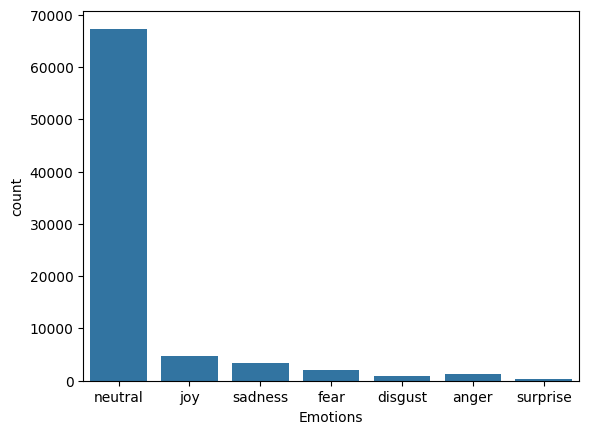

In [19]:
# Creating a countplot using Seaborn
sns.countplot(x ='Emotions', data= books)

In [13]:
books.head(6)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
5,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada


In [43]:
books = pd.read_csv('Completed-Books-with-Emotions.csv')

<Axes: xlabel='Emotions'>

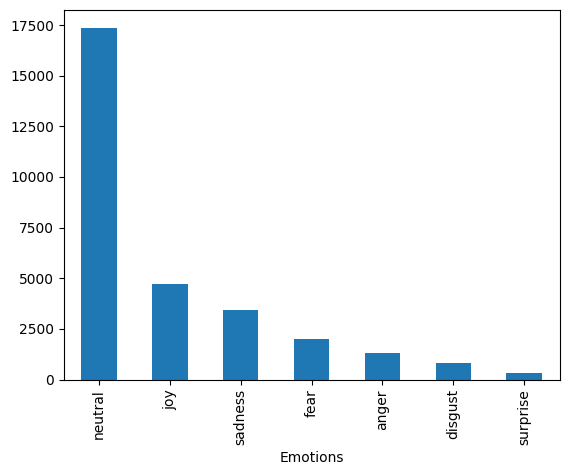

In [44]:
# Use the 'value counts' method to count occurrences of each unique value in the 'Emotions' column.
# Then, create a bar plot using the 'plot' method with the 'kind' parameter set to 'bar'.
books['Emotions'].value_counts().plot(kind='bar')

<Axes: xlabel='Emotions', ylabel='count'>

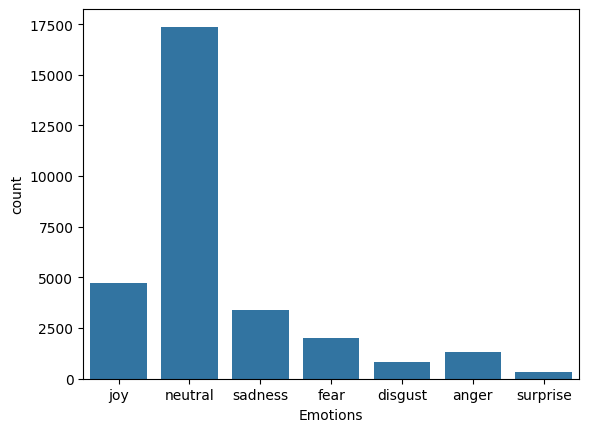

In [45]:
sns.countplot(x ='Emotions', data= books)

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Books with Emotions.csv')

def recommend_books_by_mood(user_mood, num_recommendations=5):
    # Filter books based on mood
    mood_books = df[df['Emotions'] == user_mood]

    # Select a limited number of recommendations
    recommended_books = mood_books.head(num_recommendations)

    return recommended_books

# Get user input for mood
user_mood = input("Enter your mood: ")

# Get recommended books
recommended_books = recommend_books_by_mood(user_mood)

# Display recommended books
print(f"Recommended Books for '{user_mood}':")
for index, row in recommended_books.iterrows():
    print(f"{row['Name']} by {row['Author']})")


In [ ]:
import streamlit as st
import pandas as pd

# Read the CSV file
df = pd.read_csv('book_data.csv')

def recommend_books_by_mood(user_mood, num_recommendations=5):
    # Filter books based on mood
    mood_books = df[df['Emotions'] == user_mood]

    # Select a limited number of recommendations
    recommended_books = mood_books.head(num_recommendations)

    return recommended_books

def main():
    st.title("Book Recommendation App")

    # Get user input for mood
     user_mood = st.selectbox("Select your mood:", df['Emotions'].unique())

    if st.button("Get Recommendations"):
        # Get recommended books
        recommended_books = recommend_books_by_mood(user_mood)

        # Display recommended books
        st.subheader(f"Recommended Books for '{user_mood}':")
        for index, row in recommended_books.iterrows():
            st.write(f"{row['Name']} by {row['Authors']})")

if __name__ == "__main__":
    main()
